# Build and Train Decision Trees for Regression Problems
## Purpose
In this example we will demonstrate how to:
   - Build a coreset tree for regression decision trees based on a real-world dataset.
   - Perform coreset tree vs. entire train dataset vs. random selection comparison as follows:
      - Build an LGBMRegressor model using the coreset tree service method
      - Build an LGBMRegressor model on the entire train dataset.
      - Build an LGBMRegressor model on a randomly-sampled train dataset, where the sample size exactly matches coreset size.
      - Build an LGBMRegressor model on a randomly-sampled train dataset, where the sample size is large-enough to strive to match the quality of using the coreset from the coreset tree.
      - Compare the quality of all four models built.
   - Employ coreset tree's utility functions for saving, loading and plotting the coreset tree.

In this example we'll be using the Bar Crawl dataset (https://archive.ics.uci.edu/ml/datasets/Bar+Crawl%3A+Detecting+Heavy+Drinking) after we’ve performed some feature engineering on the data. We have about 250K instances in the train set and about 28K in the test set. Our comparisons will utilize the mean squared error (https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html) as the evaluation metric.


In [1]:
import os
import warnings
from time import time
import pathlib

import numpy as np
import pandas as pd
from pathlib import Path

from sklearn.metrics import  mean_squared_error
from lightgbm import LGBMRegressor
import gdown

from dataheroes import CoresetTreeServiceDTR

warnings.simplefilter('ignore', DeprecationWarning)

In [2]:
# public folder on Google drive with data
url = "https://drive.google.com/drive/folders/1c49gInO2rTqerxXggEVd58EcstN304zD"
# create local data folder
data_path = pathlib.Path('data/BarCrawl')
data_path.mkdir(parents=True, exist_ok=True)
# download files
if not os.path.exists(str(data_path / "x_train.npy")):
    gdown.download_folder(url, quiet=True, use_cookies=False, output=str(data_path))
# load data to the memory
x_train = np.load(str(data_path / "x_train.npy"), allow_pickle=True)
x_test = np.load(str(data_path / "x_test.npy"), allow_pickle=True)
y_train = np.load(str(data_path / "y_train.npy"))
y_test = np.load(str(data_path / "y_test.npy"))

# Convert to pandas dataframe
x_train = pd.DataFrame(x_train)
x_test = pd.DataFrame(x_test)
y_train = pd.DataFrame(y_train)
y_test = pd.DataFrame(y_test)

## 1. Prepare the dataset & the testing environment

In [3]:

print(f"train size={len(x_train):,}, test size={len(x_test):,}")

# Define the number of estimators for LightGBM.
# The higher the number of estimators, the better the results will be (but the longer the time will take).
n_estimators = 500
learning_rate = 0.01

# Set the tree access level which we will be working with (default is 0=root node).
tree_query_level = 0

# Remember the number of samples for the full dataset.
n_samples_full = len(y_train)

# Define the number of samples for the comparison flavour in which a randomly-selected dataset is striving to resemble coreset dataset's quality.
n_samples_rand_large = int(n_samples_full * 0.3)

# Define method for summarizing every flavour's experimental results in one neat table.
def produce_results(experiment_group : str,
                    n_samp_full : int, n_samp_rand_large : int, n_samp_coreset : int,
                    full_score : float, rand_large_score : float, rand_csize_score : float, coreset_score : float, 
                    full_secs : float, rand_large_secs : float, rand_csize_secs : float, coreset_secs : float, 
                    ):

    df = pd.DataFrame(data={
        ' ': ['Full dataset', 'Random bigger-sized sample', 'Random smaller-sized sample', 'Coreset'],
        'Training dataset size': [n_samp_full, n_samp_rand_large, n_samp_coreset, n_samp_coreset],
        '% of full dataset': [n_samp_full / n_samp_full, n_samp_rand_large / n_samp_full, n_samp_coreset / n_samp_full, n_samp_coreset / n_samp_full],
        'Mean Square Error': [full_score, rand_large_score, rand_csize_score, coreset_score],
        'Training time (sec)': [full_secs, rand_large_secs, rand_csize_secs, coreset_secs],
    })
    last_row = pd.IndexSlice[df.index[-1], :]
    styles = [dict(selector="caption", props=[("text-align", "center"), ("font-size", "120%"), ("font-weight", "bold")])]
    s  = df.style \
        .set_properties(subset=[' '],**{'text-align':'left'}) \
        .set_properties(subset=['Training dataset size','% of full dataset','Mean Square Error','Training time (sec)'],**{'text-align':'right'}) \
        .set_properties(subset=last_row, **{'color':'green', 'font-weight':'bold'}) \
        .set_caption(f"{experiment_group} Results") \
        .format({
        'Training dataset size': '{:,}',
        '% of full dataset': '{:.2%}',
        'Mean Square Error': '{:.4f}',
        'Training time (sec)': '{:.2f}'}) \
        .hide(axis='index') \
        .set_table_styles(styles)
    return s

train size=251,707, test size=27,968


## 2. Build and train the coreset tree
Create a new service object and run `build` directly on the X, y train data.
We pass `n_instances` to initialize the coreset tree.

### 2.1. Build the coreset


In [4]:
t = time()
service_obj = CoresetTreeServiceDTR(optimized_for='training',
                                    n_instances=n_samples_full,
                                    model_cls=LGBMRegressor,
                                   )
# We pass copy=True so the build function won’t change X_train and y_train
# as they’re used later on to train the model on the entire dataset and random samples.
service_obj.build_from_df(x_train, y_train, copy=True)
coreset_build_secs = time() - t
print(f"Coreset build time (sec): {coreset_build_secs:.2f}")

Coreset build time (sec): 8.97


### 2.2 Train a model directly on the coreset tree service object

In [5]:
t = time()
# Ignore LightGBM's warning about the requirement to pass the 'sample_weight' 
# as a keyword arg and not as a positional arg.
warnings.filterwarnings(action='ignore', category=FutureWarning)

# Please note the direct usage of "service_obj.fit()".
# Provide the same parameters to the fit method as you'd provide for the model generation and 
# for tree access (required tree level).
service_obj.fit(level=tree_query_level,
                n_estimators=n_estimators,
                learning_rate=learning_rate,
               )
coreset_secs = time() - t

Using LGBMRegressor model.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000835 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12238
[LightGBM] [Info] Number of data points in the train set: 1179, number of used features: 48
[LightGBM] [Info] Start training from score 1.111076


## 3. Train the models using traditional sampling methods
### 3.1. Train a model on the entire dataset (for comparison)
We use the same (entire) training part of the dataset that was used for building the coreset tree.

In [6]:
t = time()
# Train an LightGBM model on the entire data-set.
full_model = LGBMRegressor(n_estimators=n_estimators, learning_rate=learning_rate)
full_model.fit(x_train, y_train)
full_secs = time() - t

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.043063 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12240
[LightGBM] [Info] Number of data points in the train set: 251707, number of used features: 48
[LightGBM] [Info] Start training from score -0.036432


### 3.2. Train models on samples selected randomly from the training set

### 3.2.1. Produce a randomly-selected sample matching the coreset's size

In [7]:
#We get the number of samples in the coreset, so we can randomly sample the same number of samples from the full dataset.
n_samples_coreset = service_obj.get_coreset_size(tree_query_level)
t = time()
# Train an LightGBM model on the random data-set -
# (1) Create the model, (2) randomly sample the exact size as the coreset size, and (3) train the model.
rand_csize_model = LGBMRegressor(
                            n_estimators=n_estimators,
                            learning_rate=learning_rate
                            )
rand_csize_idxs = np.random.choice(n_samples_full, n_samples_coreset, replace=False)
rand_csize_model.fit(x_train.iloc[rand_csize_idxs, :], y_train.iloc[rand_csize_idxs,:])
rand_csize_secs = time() - t

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000439 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12240
[LightGBM] [Info] Number of data points in the train set: 1179, number of used features: 48
[LightGBM] [Info] Start training from score -0.029000


### 3.2.2. Produce a randomly-selected sample striving to match coreset's quality

In [8]:
t = time()
# Train an LightGBM model on the random data-set -
# (1) Create the model, (2) randomly sample size larger than the coreset size, and (3) train the model.
rand_large_model = LGBMRegressor(
                            n_estimators=n_estimators,
                            learning_rate=learning_rate
                            )
rand_large_idxs = np.random.choice(n_samples_full, n_samples_rand_large, replace=False)
rand_large_model.fit(x_train.iloc[rand_large_idxs, :], y_train.iloc[rand_large_idxs,:])
rand_large_secs = time() - t

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012217 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12240
[LightGBM] [Info] Number of data points in the train set: 75512, number of used features: 48
[LightGBM] [Info] Start training from score -0.036338


## 4. Tree-based coreset performance comparison: coreset tree's default fit modeling approach


### 4.1. Compare models quality
Test coreset, random samples and full models on a test dataset, and compare their evaluation scores.

In [9]:
# Evaluate models. Please note the direct usage of "service_obj.predict()".
full_score = mean_squared_error(y_test, full_model.predict(x_test))
rand_large_score = mean_squared_error(y_test, rand_large_model.predict(x_test))
rand_csize_score = mean_squared_error(y_test, rand_csize_model.predict(x_test))
# pass original data to predict, due to its build-in preprocessing
coreset_score = mean_squared_error(y_test, service_obj.predict(x_test, copy=True))
produce_results("LGBMRegressor",
                n_samples_full, n_samples_rand_large, n_samples_coreset,
                full_score, rand_large_score, rand_csize_score, coreset_score, 
                full_secs, rand_large_secs, rand_csize_secs, coreset_secs, 
)

,Training dataset size,% of full dataset,Mean Square Error,Training time (sec)
Full dataset,"251,707",100.00%,0.8972,7.88
Random bigger-sized sample,"75,512",30.00%,0.9218,3.18
Random smaller-sized sample,"1,179",0.47%,0.9324,0.65
Coreset,"1,179",0.47%,0.4912,0.96


## 5. Tree utilities

### 5.1. Save the tree for future use

In [10]:
out_dir = Path('output')
out_dir.mkdir(exist_ok=True)
save_tree_name = 'train_coreset_tree'
service_obj.save(out_dir, save_tree_name, override=True)

PosixPath('output/train_coreset_tree')

### 5.2. Load the saved tree

In [11]:
service_obj = CoresetTreeServiceDTR.load(out_dir, save_tree_name)

### 5.3. Plot the tree
Plot the tree to show the loading from files was properly done and to visualize the way the data is structured inside it.

{'training': PosixPath('output/training_tree_20231204_223554.png')}

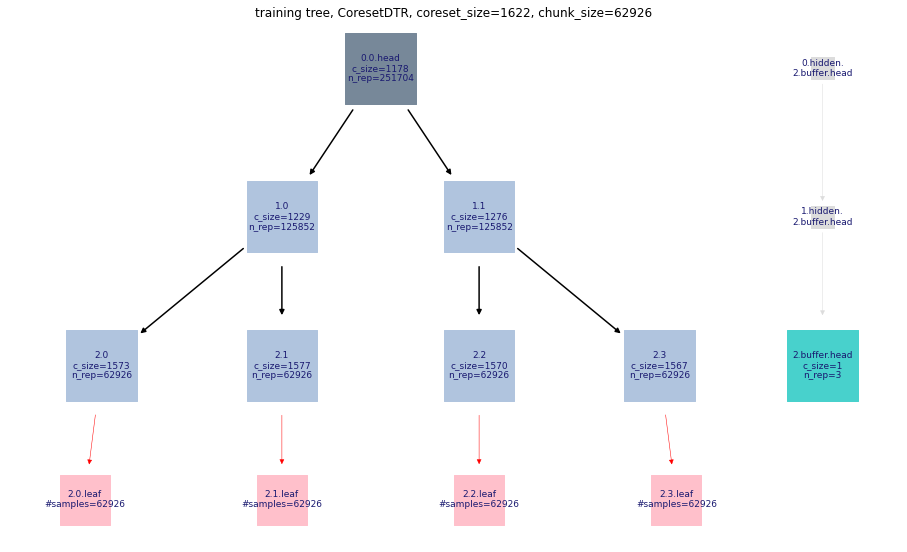

In [12]:
output_dir = Path('output')
output_dir.mkdir(exist_ok=True)
service_obj.plot(output_dir)

### 5.4. Save coreset for future use

In [13]:
final_coreset_path = os.path.join(output_dir, "final_coreset")
service_obj.save_coreset(final_coreset_path)